# Trabajo práctico - Aprendizaje Automático I

Vamos a trabajar con el dataset `weatherAUS.csv` que contiene información sobre el clima de Australia en los últimos diez años. El objetivo es usar la información del dataset para predecir los atributos `RainTomorrow` y `RainfallTomorrow` con nuevos datos. Para esto vamos a utilizar modelos de regresión lineal, regresión logística y redes neuronales.

# Análisis exploratorio y limpieza de datos

In [296]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


import warnings
warnings.simplefilter('ignore')

In [297]:
df_original = pd.read_csv('datasets/weatherAUS.csv', index_col=0)

# Columnas

* **Sunshine:** Numero de horas de sol en el dia
* **Rainfall:** Cantidad de lluvia en el dia en mm
* **Evaporation:** La denominada evaporación del recipiente Clase A (mm) en el período de 24 horas a las 9 a.m.
* **WindGustDir:** La dirección de la ráfaga de viento más fuerte en las 24 horas hasta la medianoche
* **WindGustSpeed:** La velocidad (km/h) de la ráfaga de viento más fuerte en las 24 horas previas a la medianoche
* **WindDir9am:** Dirección del viento a las 9 a.m.
* **WindDir3pm:** direccion del viento alas 3pm
* **WindSpeed9am:** Velocidad del viento (km/h) promediada durante 10 minutos antes de las 9 a.m.
* **WindSpeed3pm:** Velocidad del viento (km/h) promediada durante 10 minutos antes de las 3 p.m.
* **Humidity9am:** Humedad (porcentaje) a las 15:00 horas
* **Humidity3pm:**
* **Pressure9am:** La presión atmosférica (hpa) se redujo al nivel medio del mar a las 9 a. m.
* **Pressure3pm:**
* **Cloud9am:** Fracción del cielo oscurecida por las nubes a las 9:00 horas. Esto se mide en "oktas", que son una unidad de octavos. Registra cuántas octavas partes del cielo están oscurecidas por las nubes. Una medida 0 indica cielo completamente despejado mientras que un 8 indica que está completamente nublado.
* **Cloud3pm:**
* **Temp9am:** Temperatura (grados C) a las 9 a.m.
* **Temp3pm:**
* **RainToday:** Booleano: 1 si la precipitación (mm) en las 24 horas hasta las 9 a. m. excede 1 mm; de lo contrario, 0
* **RainTomorrow:** La cantidad de lluvia del día siguiente en mm. Se utiliza para crear la variable de respuesta RainTomorrow. Una especie de medida del "riesgo".
* **RainfallTomorrow:** ESTA COLUMNA LA AGREGARON LOS PROFES!!!!!

https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package

Para entrenar los modelos solamente vamos a usar cinco ciudades del dataset

In [298]:
ciudades = ['Sydney',
            'SydneyAirport',
            'Canberra',
            'Melbourne',
            'MelbourneAirport']

df = df_original[df_original['Location']\
                 .isin(ciudades)]\
                 .copy()\
                 .reset_index(drop=True)

In [299]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15986 entries, 0 to 15985
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Date              15986 non-null  object 
 1   Location          15986 non-null  object 
 2   MinTemp           15495 non-null  float64
 3   MaxTemp           15500 non-null  float64
 4   Rainfall          15199 non-null  float64
 5   Evaporation       14280 non-null  float64
 6   Sunshine          14038 non-null  float64
 7   WindGustDir       14529 non-null  object 
 8   WindGustSpeed     14531 non-null  float64
 9   WindDir9am        15291 non-null  object 
 10  WindDir3pm        15696 non-null  object 
 11  WindSpeed9am      15725 non-null  float64
 12  WindSpeed3pm      15737 non-null  float64
 13  Humidity9am       15416 non-null  float64
 14  Humidity3pm       15461 non-null  float64
 15  Pressure9am       15251 non-null  float64
 16  Pressure3pm       15260 non-null  float6

Ordenamos el dataframe por localidad y fecha porque vamos a usar el metodo de la interpolacion lienal para llenar valores faltantes y tambien el metodo de valor mas cercano valido. 

In [300]:
df.sort_values(['Location', 'Date'], inplace=True)

Imputamos los datos que no son medidas estadicas antes de separar el dataset

## MinTemp y MaxTemp

Para estas variables decidimos usar una interpolación, ya que la temperatura de los días faltantes probablemente se encuentre en algún punto entre la temperatura del día anterior y la del día posterior.

In [301]:
df['MinTemp'].interpolate(method='linear', inplace=True)
df['MaxTemp'].interpolate(method='linear', inplace=True)

## WindDir 

Para la direcciones viento elegimos llenarla con el valor siguiete valido ya que es daset esta ordenado por fecha. 

In [302]:
df['WindDir9am'].fillna(method='ffill', inplace=True)
df['WindDir3pm'].fillna(method='ffill', inplace=True)

## RainToday y RainTomorrow

Los valores Nan de estas dos variables son muy pocos por eso decidimos eliminarlos.

In [303]:
df.RainToday.isna().sum()

787

In [304]:
df.RainTomorrow.isna().sum()

787

In [305]:
df.dropna(subset=["RainTomorrow"],inplace=True)


In [306]:
df.dropna(subset=["RainToday"],inplace=True)

Separamos el dataset para en entrenamiento y prueba

In [307]:
x_reg = df.drop(columns=['RainTomorrow', 'RainfallTomorrow'])
y_reg = df['RainfallTomorrow']

x_clas = x_reg
y_clas = df['RainTomorrow']

x_train_reg, x_test_reg, y_train_reg, y_test_reg = train_test_split(x_reg, y_reg, test_size=0.2, random_state=42)
x_train_clas, x_test_clas, y_train_clas, y_test_clas = train_test_split(x_clas, y_clas, test_size=0.2, random_state=42)

In [308]:
df_reg  = pd.concat([x_train_reg, y_train_reg], axis=1)
df_clas = pd.concat([x_train_clas, y_train_clas], axis=1)

## ¿Está balanceado el dataset?

### Dataset regresión

El dataset no está balanceado porque la variable independietne que queremos predecir tiene muchos valores iguales a $0$.

<AxesSubplot: >

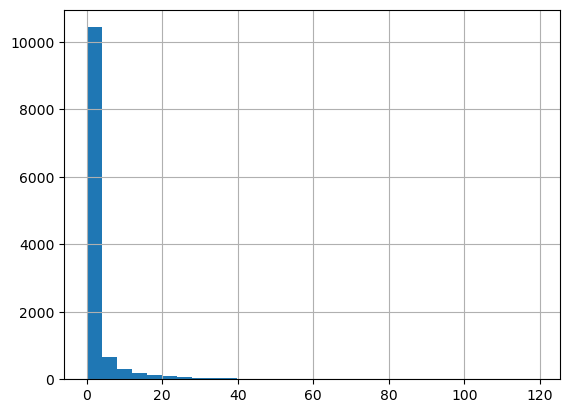

In [310]:
y_train_reg.hist(bins=30)

In [311]:
y_train_reg.shape

(12028,)

In [312]:
y_train_reg.value_counts()

0.0     7743
0.2      666
0.4      327
0.6      231
0.8      152
        ... 
41.8       1
54.4       1
40.6       1
57.8       1
53.0       1
Name: RainfallTomorrow, Length: 261, dtype: int64

In [313]:
f'{7784/12788:.2f}'

'0.61'

En el histograma vemos gráficamente que el dataset está desbalanceado, ya que la moda es $0$ y con los valores vemos que aproximadamente el $61\%$ de los valores de la variable a predecir son $0$.

### Dataset clasificación

<AxesSubplot: >

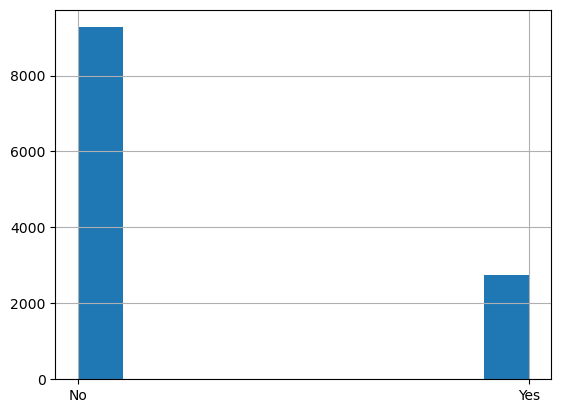

In [314]:
y_train_clas.hist()

In [315]:
y_train_clas.shape

(12028,)

In [316]:
y_train_clas.value_counts()

No     9270
Yes    2758
Name: RainTomorrow, dtype: int64

In [317]:
f'{9337/12788:.2f}'

'0.73'

Para el caso del dataset que usaremos para la clasificación también vemos que hay un importante desbalanceo, ya que el $73\%$ de sus valores pertenecen a una de las clases.

## Imputación de datos

## WindGustDir 

Esta variable en un momento habiamos decidido eliminarla(tenia un años con valores nan) pero ahora creemos que es mejor llenarla con la moda en funcion a la localidad y estacion del año. 

In [318]:
df_reg["Date"] = pd.to_datetime(df_reg["Date"])
df_reg['Month'] = df_reg["Date"].dt.month

In [319]:
df_clas["Date"] = pd.to_datetime(df_clas["Date"])
df_clas['Month'] = df_clas["Date"].dt.month

In [320]:
df_reg['Estacion'] = df_reg["Month"].map({1: 'Summer', 2: 'Summer', 3: 'Autumn', 4: 'Autumn', 5: 'Autumn', 6: 'Winter', 7: 'Winter', 8: 'Winter', 9: 'Spring', 10: 'Spring', 11: 'Spring', 12: 'Summer'})


In [321]:
df_clas['Estacion'] = df_clas["Month"].map({1: 'Summer', 2: 'Summer', 3: 'Autumn', 4: 'Autumn', 5: 'Autumn', 6: 'Winter', 7: 'Winter', 8: 'Winter', 9: 'Spring', 10: 'Spring', 11: 'Spring', 12: 'Summer'})

In [322]:
def temporada_ubicacion(dataframe, columna_a_rellenar, columna_ubicacion, columna_temporada):
    
    moda_por_ubicacion_temporada = dataframe.groupby([columna_ubicacion, columna_temporada])[columna_a_rellenar].apply(lambda x: x.mode().iloc[0])

    dataframe[columna_a_rellenar] = dataframe.apply(
        lambda fila: moda_por_ubicacion_temporada[fila[columna_ubicacion], fila[columna_temporada]] if pd.isna(fila[columna_a_rellenar]) else fila[columna_a_rellenar],
        axis=1
    )

    return dataframe


In [323]:

df_reg= temporada_ubicacion(df_reg, "WindGustDir", "Location", "Estacion")

In [324]:
df_clas= temporada_ubicacion(df_clas, "WindGustDir", "Location", "Estacion")

### Rainfall

Para completar la variable `Rainfall` vamos a usar la moda de la distribución que es `0.0`, eso lo podemos comprobar con el siguiente histograma y loop.

Text(0.5, 1.0, 'Dataset Clasificación')

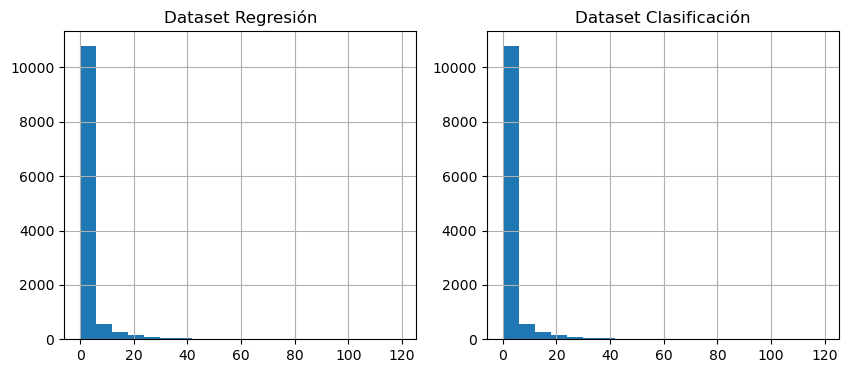

In [325]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
df_reg['Rainfall'].hist(bins=20)
plt.title('Dataset Regresión')
plt.subplot(122)
df_clas['Rainfall'].hist(bins=20)
plt.title('Dataset Clasificación')

In [326]:
for ciudad in ciudades:
    rain = \
        df_reg[df_reg['Location'] == ciudad]['Rainfall'].mode()[0]
    print(f'{ciudad + ":":17} {rain}')

Sydney:           0.0
SydneyAirport:    0.0
Canberra:         0.0
Melbourne:        0.0
MelbourneAirport: 0.0


In [327]:
for ciudad in ciudades:
    rain = \
        df_clas[df_clas['Location'] == ciudad]['Rainfall'].mode()[0]
    print(f'{ciudad + ":":17} {rain}')

Sydney:           0.0
SydneyAirport:    0.0
Canberra:         0.0
Melbourne:        0.0
MelbourneAirport: 0.0


In [328]:
df_reg['Rainfall'].fillna(0.0, inplace=True)
df_clas['Rainfall'].fillna(0.0, inplace=True)

### Evaporation

En esta variable vemos que la distribución es bastante simétrica, además la media y la mediana tiene valores muy cercanos, en esta caso no hay sesgo, por lo tanto decidimos completar los valores faltante con la media.

Text(0.5, 1.0, 'Dataset Clasificación')

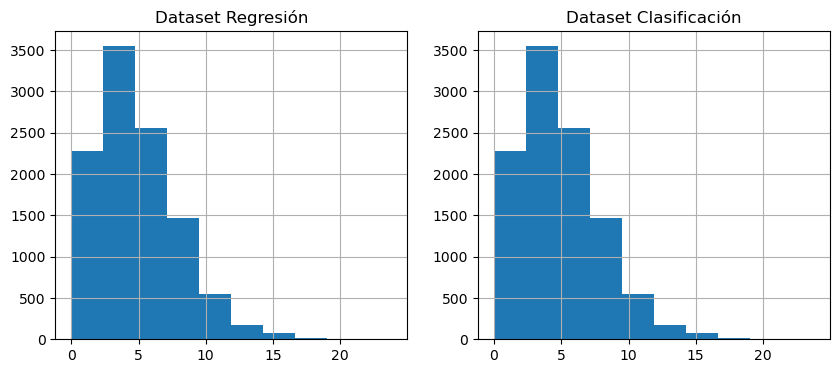

In [329]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
df_reg['Evaporation'].hist()
plt.title('Dataset Regresión')
plt.subplot(122)
df_clas['Evaporation'].hist()
plt.title('Dataset Clasificación')

In [330]:
df_reg['Evaporation'].mean(), df_reg['Evaporation'].median()

(4.873762051858092, 4.2)

In [331]:
df_clas['Evaporation'].mean(), df_clas['Evaporation'].median()

(4.873762051858092, 4.2)

In [332]:
df_reg['Evaporation'].fillna(df_reg['Evaporation'].mean(), inplace=True)
df_clas['Evaporation'].fillna(df_clas['Evaporation'].mean(), inplace=True)

### Sunshine

En este histograma vemos que la distribución es bimodal, por lo que para imputar los valores faltantes vamos usar la mediana, ya que la media está sesgada por la gran cantidad de `0.0`

Text(0.5, 1.0, 'Dataset Clasificación')

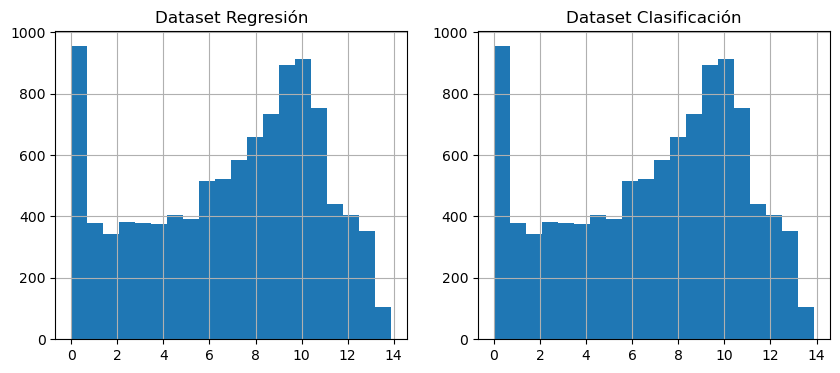

In [333]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
df_reg['Sunshine'].hist(bins=20)
plt.title('Dataset Regresión')
plt.subplot(122)
df_clas['Sunshine'].hist(bins=20)
plt.title('Dataset Clasificación')

In [334]:
df_reg['Sunshine'].fillna(df_reg['Sunshine'].median(), inplace=True)
df_clas['Sunshine'].fillna(df_clas['Sunshine'].median(), inplace=True)

### WindSpeed

En este caso observando los histogramas vemos que podemos completar los valores faltantes con la media.

Text(0.5, 1.0, 'Clasificación - WindSpeed3pm')

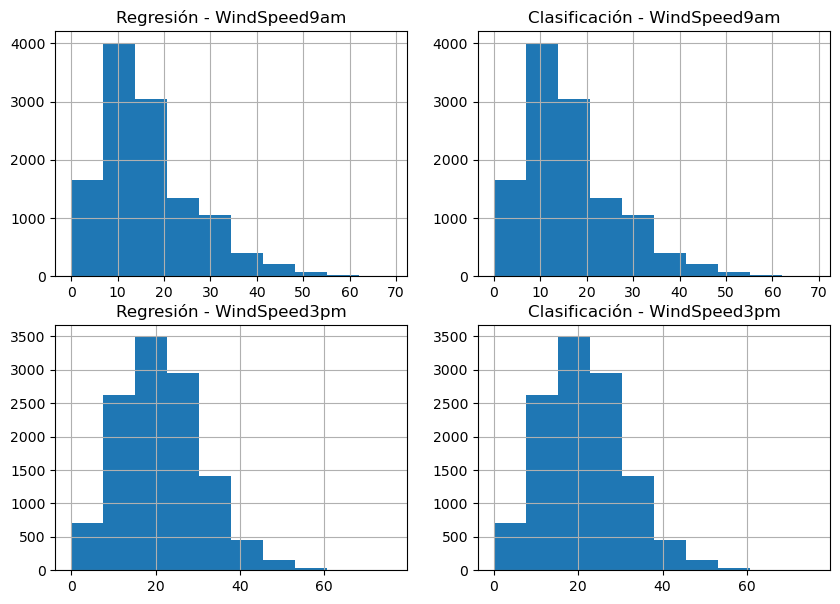

In [335]:
plt.figure(figsize=(10, 7))

plt.subplot(221)
df_reg['WindSpeed9am'].hist()
plt.title('Regresión - WindSpeed9am')
plt.subplot(222)
df_clas['WindSpeed9am'].hist()
plt.title('Clasificación - WindSpeed9am')
plt.subplot(223)
df_reg['WindSpeed3pm'].hist()
plt.title('Regresión - WindSpeed3pm')
plt.subplot(224)
df_clas['WindSpeed3pm'].hist()
plt.title('Clasificación - WindSpeed3pm')

In [336]:
df_reg['WindSpeed9am'].fillna(df_reg['WindSpeed9am'].mean(),inplace=True)
df_clas['WindSpeed9am'].fillna(df_clas['WindSpeed9am'].mean(),inplace=True)

df_reg['WindSpeed3pm'].fillna(df_reg['WindSpeed3pm'].mean(),inplace=True)
df_clas['WindSpeed3pm'].fillna(df_clas['WindSpeed3pm'].mean(),inplace=True)

### WindSGustSpeed

Vemos que la media y la media son similares esto nos dice que la distribucion es simetrica por lo cual lo llenamos con la mediana

In [337]:
df.WindGustSpeed.describe()

count    13602.000000
mean        44.290619
std         14.948251
min         11.000000
25%         33.000000
50%         43.000000
75%         54.000000
max        122.000000
Name: WindGustSpeed, dtype: float64

In [338]:
df_reg['WindSpeed3pm'].fillna(df_reg['WindSpeed3pm'], inplace=True)
df_clas['WindSpeed3pm'].fillna(df_clas['WindSpeed3pm'], inplace=True)

### Humidity

Los valores Nan de las variables humedad los completamos con la media 

In [339]:
df_reg['Humidity9am'].describe()

count    11961.000000
mean        68.862553
std         15.649308
min         11.000000
25%         59.000000
50%         70.000000
75%         80.000000
max        100.000000
Name: Humidity9am, dtype: float64

Text(0.5, 1.0, 'Clasificación - Humidity3pm')

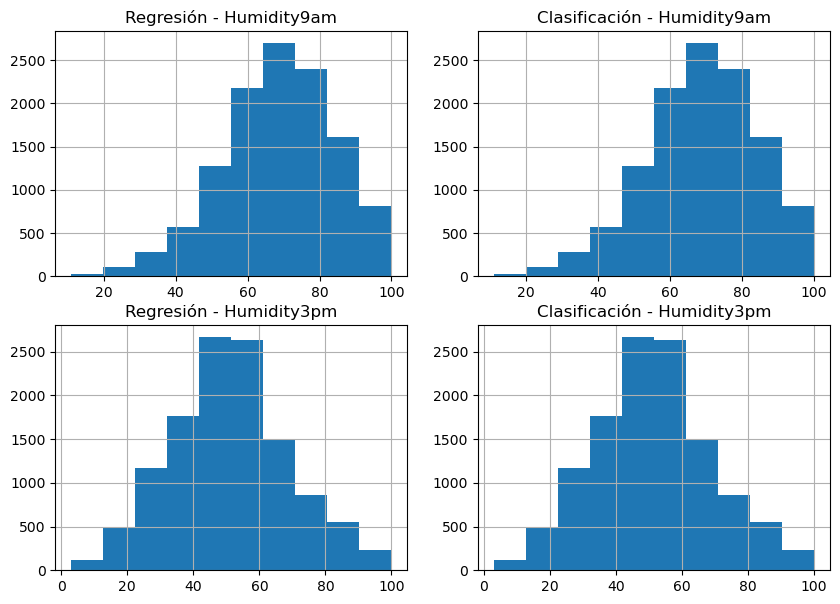

In [340]:
plt.figure(figsize=(10, 7))

plt.subplot(221)
df_reg['Humidity9am'].hist()
plt.title('Regresión - Humidity9am')
plt.subplot(222)
df_clas['Humidity9am'].hist()
plt.title('Clasificación - Humidity9am')
plt.subplot(223)
df_reg['Humidity3pm'].hist()
plt.title('Regresión - Humidity3pm')
plt.subplot(224)
df_clas['Humidity3pm'].hist()
plt.title('Clasificación - Humidity3pm')

In [341]:
df_reg['Humidity9am']\
    .fillna(
        df_reg['Humidity9am'].mean(),
        inplace=True)

In [342]:
df_clas['Humidity9am']\
    .fillna(
        df_clas['Humidity9am'].mean(),
        inplace=True)

In [343]:
df_clas.Humidity3pm.describe()

count    11988.000000
mean        51.199867
std         17.772806
min          3.000000
25%         39.000000
50%         51.000000
75%         62.000000
max        100.000000
Name: Humidity3pm, dtype: float64

In [344]:
df_clas["Humidity3pm"].fillna(df_clas["Humidity3pm"].mean(), inplace=True)

In [345]:
df_reg["Humidity3pm"].fillna(df_reg["Humidity3pm"].mean(), inplace=True)

### PRESSURE

Los valores Nan de esta variables los vamos a llenar con la media. 

Text(0.5, 1.0, 'Clasificación - Pressure3pm')

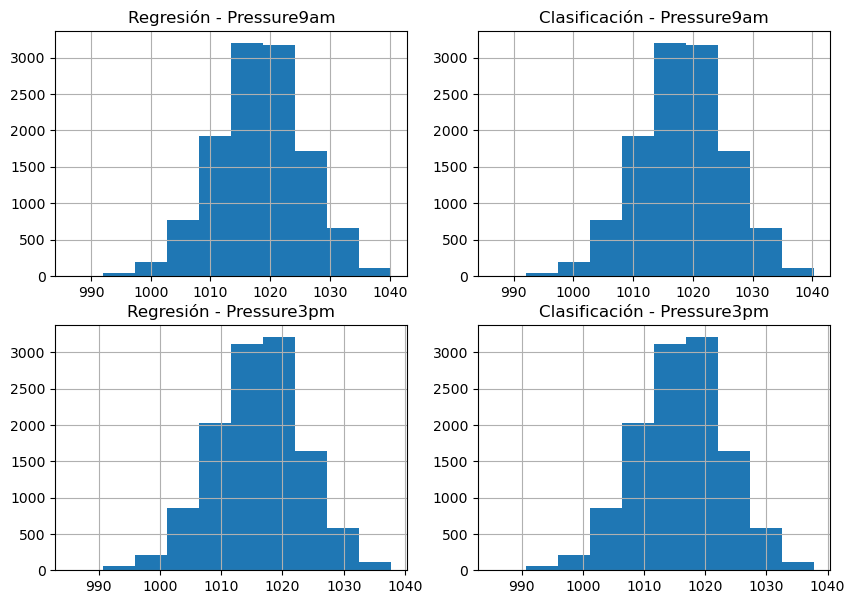

In [346]:
plt.figure(figsize=(10, 7))

plt.subplot(221)
df_reg['Pressure9am'].hist()
plt.title('Regresión - Pressure9am')
plt.subplot(222)
df_clas['Pressure9am'].hist()
plt.title('Clasificación - Pressure9am')
plt.subplot(223)
df_reg['Pressure3pm'].hist()
plt.title('Regresión - Pressure3pm')
plt.subplot(224)
df_clas['Pressure3pm'].hist()
plt.title('Clasificación - Pressure3pm')

In [347]:
df_clas["Pressure3pm"].describe()

count    11823.000000
mean      1016.055453
std          7.277343
min        985.500000
25%       1011.200000
50%       1016.300000
75%       1021.000000
max       1037.800000
Name: Pressure3pm, dtype: float64

In [348]:
df_clas["Pressure9am"].describe()

count    11815.000000
mean      1018.325713
std          7.398393
min        986.700000
25%       1013.500000
50%       1018.500000
75%       1023.300000
max       1040.300000
Name: Pressure9am, dtype: float64

In [349]:
df_reg["Pressure9am"].describe()

count    11815.000000
mean      1018.325713
std          7.398393
min        986.700000
25%       1013.500000
50%       1018.500000
75%       1023.300000
max       1040.300000
Name: Pressure9am, dtype: float64

In [350]:
df_reg["Pressure9am"].fillna(df_reg["Pressure9am"].mean(), inplace=True)
df_reg["Pressure3pm"].fillna(df_reg["Pressure3pm"].mean(), inplace=True)

df_clas["Pressure9am"].fillna(df_clas["Pressure9am"].mean(), inplace=True)
df_clas["Pressure3pm"].fillna(df_clas["Pressure3pm"].mean(), inplace=True)

### CLOUD 

Los valores Nan de esta variable los vamos a llenar con la mediana, ya que en este caso la mediana es mas robusta que el promedio por la distribucion del la variable.

Text(0.5, 1.0, 'Clasificación - Cloud3pm')

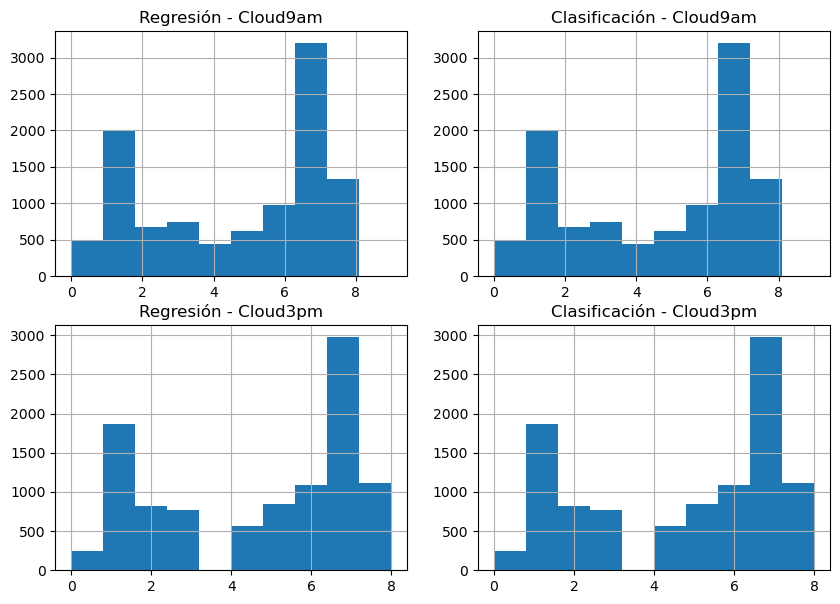

In [351]:
plt.figure(figsize=(10, 7))

plt.subplot(221)
df_reg['Cloud9am'].hist()
plt.title('Regresión - Cloud9am')
plt.subplot(222)
df_clas['Cloud9am'].hist()
plt.title('Clasificación - Cloud9am')
plt.subplot(223)
df_reg['Cloud3pm'].hist()
plt.title('Regresión - Cloud3pm')
plt.subplot(224)
df_clas['Cloud3pm'].hist()
plt.title('Clasificación - Cloud3pm')

In [352]:
df_clas["Cloud3pm"].describe()

count    10287.000000
mean         4.718382
std          2.594606
min          0.000000
25%          2.000000
50%          6.000000
75%          7.000000
max          8.000000
Name: Cloud3pm, dtype: float64

In [353]:
df_clas["Cloud9am"].describe()

count    10482.000000
mean         4.721618
std          2.734851
min          0.000000
25%          2.000000
50%          6.000000
75%          7.000000
max          9.000000
Name: Cloud9am, dtype: float64

In [354]:
df_clas["Cloud3pm"].fillna(df_clas["Cloud3pm"].median(), inplace=True)
df_clas["Cloud9am"].fillna(df_clas["Cloud9am"].median(), inplace=True)

df_reg["Cloud3pm"].fillna(df_reg["Cloud3pm"].median(), inplace=True)
df_reg["Cloud9am"].fillna(df_reg["Cloud9am"].median(), inplace=True)

### TEMP 

Las variables de temperatura de la mañana y tarde seran completadas con el promedio, ya que la distribucion es asimetrica, ademas la media y la media se encuentran muy proximas

Text(0.5, 1.0, 'Clasificación - Temp3pm')

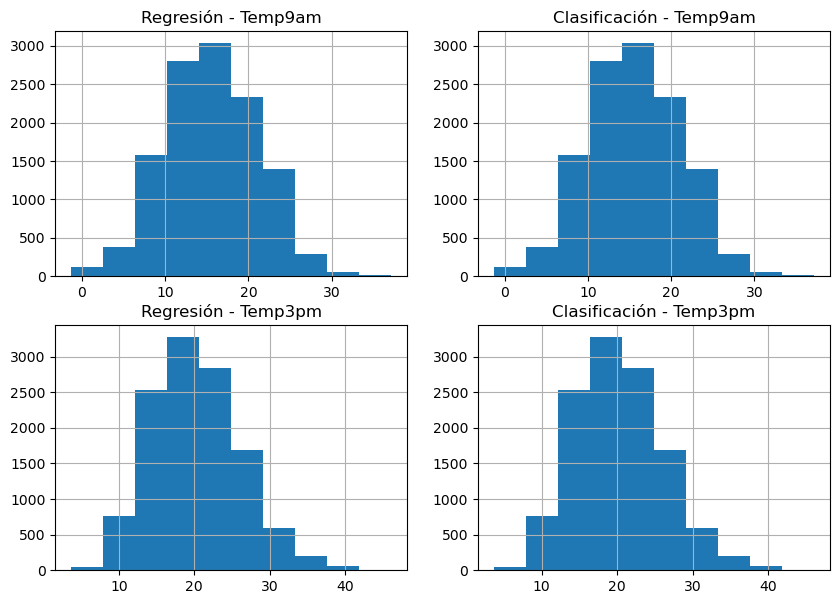

In [355]:
plt.figure(figsize=(10, 7))

plt.subplot(221)
df_reg['Temp9am'].hist()
plt.title('Regresión - Temp9am')
plt.subplot(222)
df_clas['Temp9am'].hist()
plt.title('Clasificación - Temp9am')
plt.subplot(223)
df_reg['Temp3pm'].hist()
plt.title('Regresión - Temp3pm')
plt.subplot(224)
df_clas['Temp3pm'].hist()
plt.title('Clasificación - Temp3pm')

In [356]:
df_reg['Temp3pm'].mean(), df_reg['Temp3pm'].median() 

(20.28962876643915, 19.9)

In [357]:
df_reg['Temp9am'].mean(), df_reg['Temp9am'].median() 

(15.590394539703679, 15.4)

In [358]:
df_reg["Temp9am"].fillna(df_reg["Temp9am"].mean(), inplace=True)
df_reg["Temp3pm"].fillna(df_reg["Temp3pm"].mean(), inplace=True)

df_clas["Temp9am"].fillna(df_clas["Temp9am"].mean(), inplace=True)
df_clas["Temp3pm"].fillna(df_clas["Temp3pm"].mean(), inplace=True)

### CODIFICAMOS LAS VARIABLES CATEGORICAS

In [359]:
df_clas['RainToday'] = df_clas['RainToday'].replace({'Yes': 1, 'No': 0})
df_reg['RainToday'] = df_reg['RainToday'].replace({'Yes': 1, 'No': 0})

La variable RainTomorrow solo la usamos en el dataset de clasificacion, es otro cambio que relizamos porque en los noobok anteriores la habiamos usado en el modelo de regresion lineal y esto nos estaria provocando una fuga de datos.

In [360]:
df_clas['RainTomorrow'] = df_clas['RainTomorrow'].replace({'Yes': 1, 'No': 0})

Voy a eliminar columna que no vamos a usar

In [361]:
categoricas = ['Location', "Month", "Estacion", "Date"]
df_clasi = df_clas.drop(labels=categoricas, axis=1).copy()
df_regre = df_reg.drop(labels=categoricas, axis=1).copy()

In [362]:
df_regre = pd.get_dummies(df_regre, columns=["WindGustDir", "WindDir9am", "WindDir3pm"], drop_first=True)

In [363]:
df_clasi = pd.get_dummies(df_clasi, columns=["WindGustDir", "WindDir9am", "WindDir3pm"], drop_first=True)

### NORMALIZACION DE LAS VARIABLES CUANTITATIVAS 

In [364]:
df_regre.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12028 entries, 10395 to 11358
Data columns (total 63 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MinTemp           12028 non-null  float64
 1   MaxTemp           12028 non-null  float64
 2   Rainfall          12028 non-null  float64
 3   Evaporation       12028 non-null  float64
 4   Sunshine          12028 non-null  float64
 5   WindGustSpeed     10902 non-null  float64
 6   WindSpeed9am      12028 non-null  float64
 7   WindSpeed3pm      12028 non-null  float64
 8   Humidity9am       12028 non-null  float64
 9   Humidity3pm       12028 non-null  float64
 10  Pressure9am       12028 non-null  float64
 11  Pressure3pm       12028 non-null  float64
 12  Cloud9am          12028 non-null  float64
 13  Cloud3pm          12028 non-null  float64
 14  Temp9am           12028 non-null  float64
 15  Temp3pm           12028 non-null  float64
 16  RainToday         12028 non-null  in

In [365]:
columnas = ["MinTemp", "MaxTemp", "Rainfall", "Evaporation", "Sunshine", "WindGustSpeed", "WindSpeed9am", "WindSpeed3pm", "Humidity9am","Humidity3pm", "Pressure9am", "Pressure3pm", "Cloud9am", "Cloud3pm", "Temp9am", "Temp3pm", "RainToday"]

In [366]:
scaler = StandardScaler()

In [367]:
df_regre[columnas] = scaler.fit_transform(df_regre[columnas])

In [368]:
df_clasi[columnas] = scaler.fit_transform(df_clasi[columnas])

### MATRIZ DE CORRELACION 

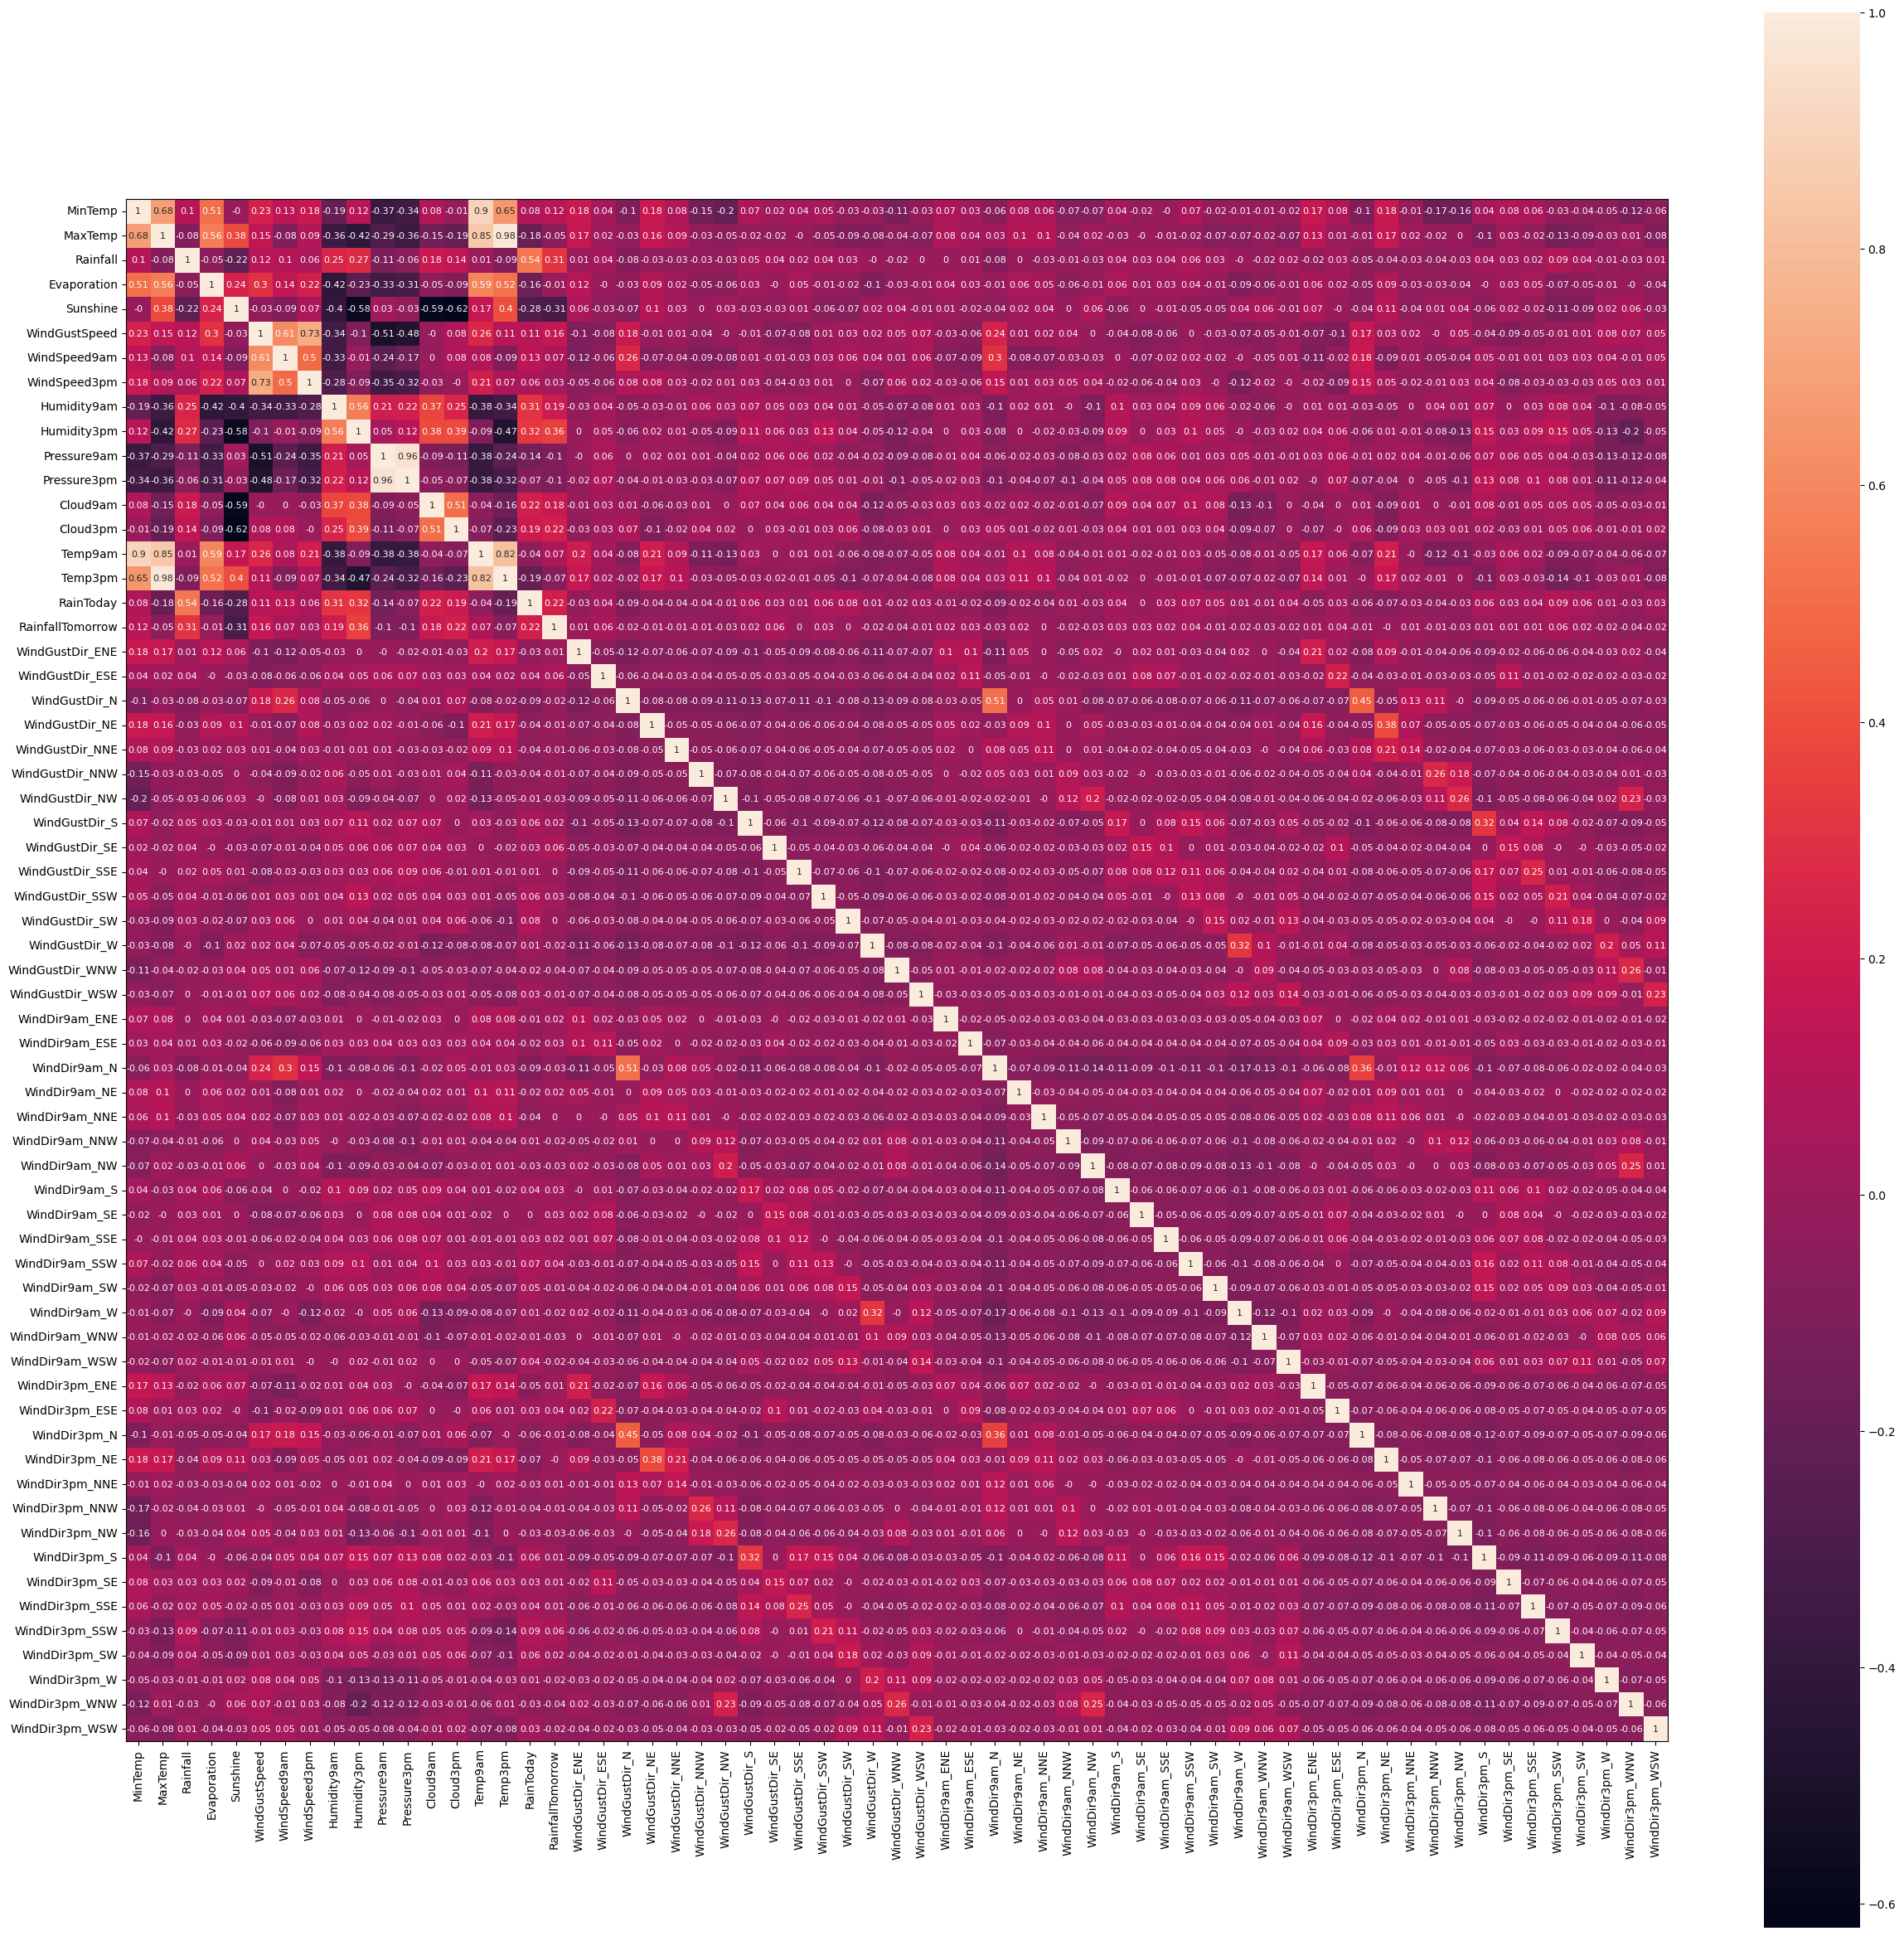

In [369]:
plt.figure(figsize=(30, 30))

heatmap = sns.heatmap(
    df_regre.corr().round(2),
    annot=True,
    square=True,
    annot_kws={'size': 8},  
)

for _, spine in heatmap.spines.items():
    spine.set_visible(True)
plt.yticks(rotation=0)
plt.xticks(rotation=90)

plt.show()


Aca en la matriz de correlacion  podemos que variables tiene mas correlacion con la variable que queremos predecir, podemos ver si su correlacon es positiva o negativa, si la correllacion es alta o baja, pero no vamos a usar el criterio de eliminar variables por su correlacion con la variable a predecir. 

### SCATTER PLOT entre variable a predecir  RainfallTomorrow y el resto de las variables cuantitativas

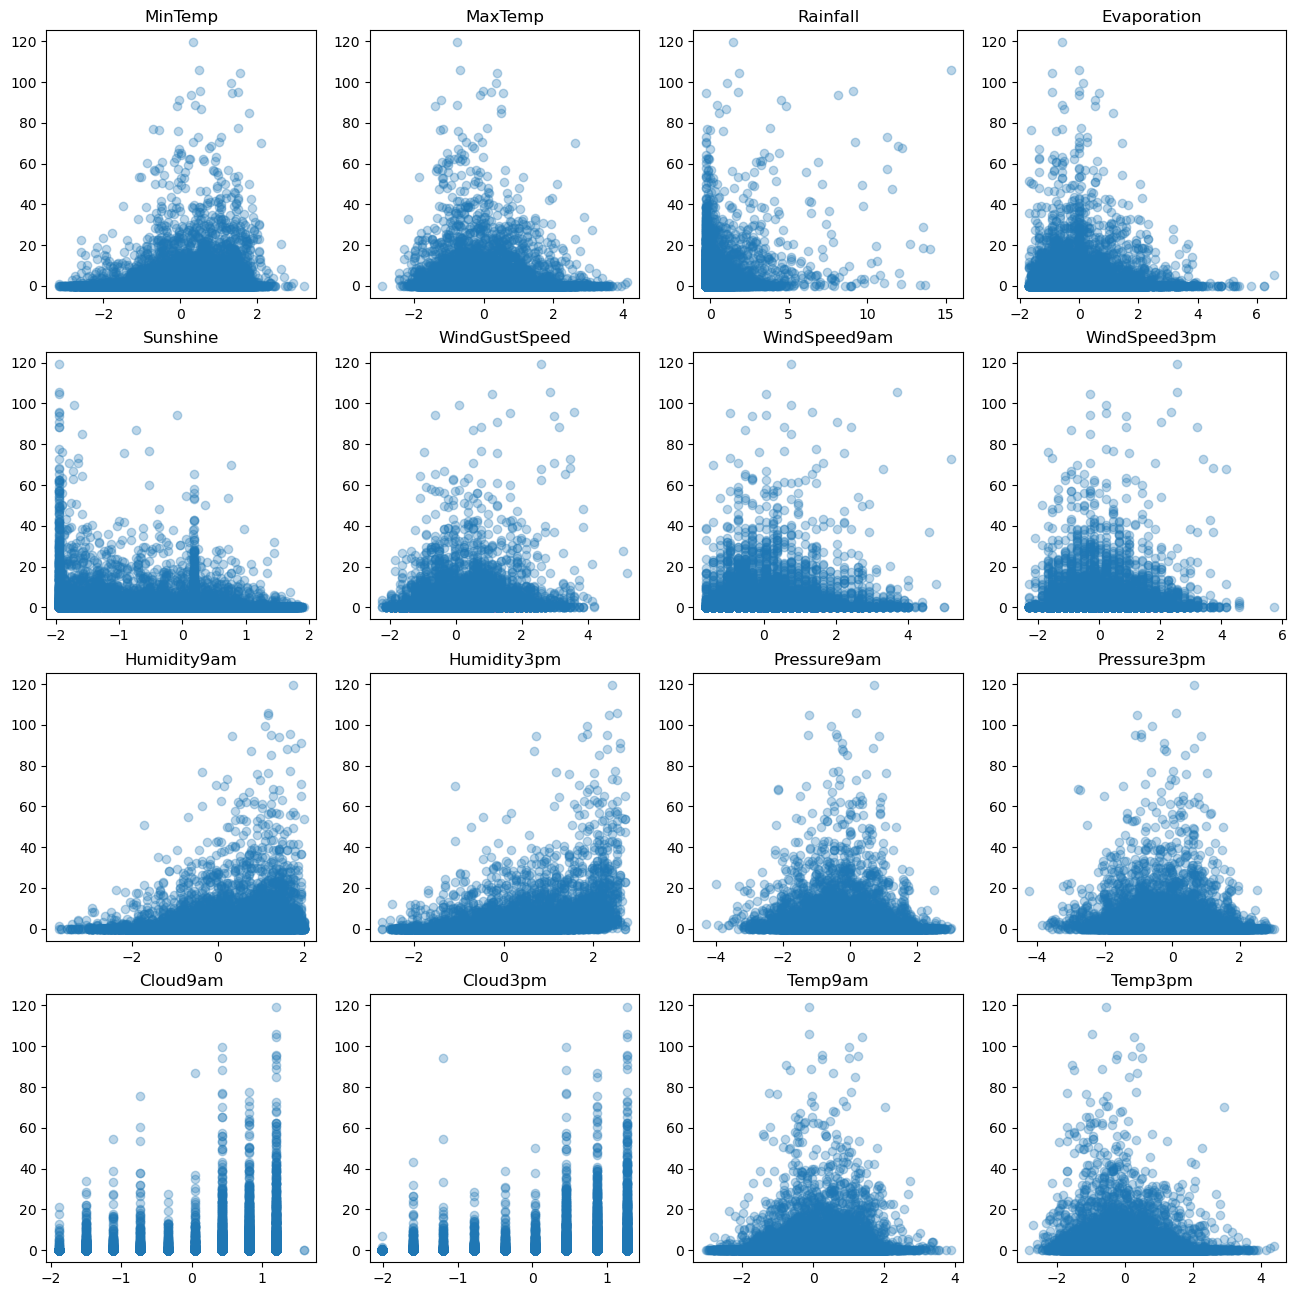

In [370]:
plt.figure(figsize=(16, 16))

for idx, col in enumerate(df_regre.columns[:16], start=1):  
    plt.subplot(4, 4, idx)
    plt.scatter(data=df_regre, x=col, y='RainfallTomorrow', alpha=.3)
    plt.title(col)


Vemos que no hay fuertes asocianes lieneales positivas, ni negativas.  

### VOLVEMOS A SEPARAR LOS DATFRAME

In [371]:
x_train_regre = df_regre.iloc[:, :-1]  
y_train_regre = df_regre.iloc[:, -1]  

x_train_clasi = df_clasi.iloc[:, :-1]  
y_train_clasi = df_clasi.iloc[:, -1]  


In [372]:
x_train_regre.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12028 entries, 10395 to 11358
Data columns (total 62 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MinTemp           12028 non-null  float64
 1   MaxTemp           12028 non-null  float64
 2   Rainfall          12028 non-null  float64
 3   Evaporation       12028 non-null  float64
 4   Sunshine          12028 non-null  float64
 5   WindGustSpeed     10902 non-null  float64
 6   WindSpeed9am      12028 non-null  float64
 7   WindSpeed3pm      12028 non-null  float64
 8   Humidity9am       12028 non-null  float64
 9   Humidity3pm       12028 non-null  float64
 10  Pressure9am       12028 non-null  float64
 11  Pressure3pm       12028 non-null  float64
 12  Cloud9am          12028 non-null  float64
 13  Cloud3pm          12028 non-null  float64
 14  Temp9am           12028 non-null  float64
 15  Temp3pm           12028 non-null  float64
 16  RainToday         12028 non-null  fl

In [373]:
y_train_regre.info()

<class 'pandas.core.series.Series'>
Int64Index: 12028 entries, 10395 to 11358
Series name: WindDir3pm_WSW
Non-Null Count  Dtype
--------------  -----
12028 non-null  uint8
dtypes: uint8(1)
memory usage: 105.7 KB


# Regresión Lineal

In [374]:
from sklearn.linear_model import LinearRegression

In [375]:
reg = LinearRegression()

reg.fit(x_train_regre, y_train_regre)

ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

# Regresión logística

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
logistica = LogisticRegression()

# logistica.fit(x_train_clas, y_train_clas)

# Redes neuronales

# Conclusiones finales